In [6]:
# INCEPTION V3 NEURAL NETWORK TO CLASSIFY IMAGES INTO ONE OF THE 10 DISTRACTIONS

# The method to use and implement this model is outlined in the ReadMe file

# Sources cited:
# https://keras.io/guides/transfer_learning/
# https://keras.io/api/applications/#usage-examples-for-image-classification-models
# https://keras.io/api/data_loading/
# https://medium.com/@italojs/saving-your-weights-for-each-epoch-keras-callbacks-b494d9648202
# https://datascience.stackexchange.com/questions/104572/does-validation-split-in-tf-keras-preprocessing-image-dataset-from-directory-res
# Code also borrowed from the solution of P-Set 2 (CAS CS 523, Deep Learning, Professor Sarah)

# The dataset is located on the Google Drive, Link:
# https://drive.google.com/drive/folders/1XQwlyOjZL0dPDbWagURrSqa1dC6rDkgW?usp=sharing

# importing files and libraries
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
import glob
import keras
from keras.preprocessing.image import smart_resize
from PIL import Image
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import Sequence
from keras.callbacks import ModelCheckpoint
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score , recall_score, f1_score
from sklearn.metrics import top_k_accuracy_score


In [2]:
# mounting Google drive
# the dataset is stored on the drive

from google.colab import drive 
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [ ]:
#folder='/content/drive/MyDrive/CS523_Deep_Learning/Data/train/c'

#filelist = glob.glob(folder + '0' + '/*.jpg')
#train_images = np.array([np.array(Image.open(fname)) for fname in filelist])
#train_labels = np.zeros((train_images.shape[0],), dtype=int)

#for i in range(1,10):
#    folder_i = folder+str(i)
#    filelist = glob.glob(folder_i + '/*.jpg')
#    temp=np.array([np.array(Image.open(fname)) for fname in filelist])
#    train_images = np.vstack((train_images, temp))
#    train_labels = np.hstack((train_labels, np.zeros((temp.shape[0],), dtype=int) + i))


In [3]:
#folder='/content/drive/MyDrive/CS523_Deep_Learning/Data/TestData/c'

#filelist = glob.glob(folder + '0' + '/*.jpg')
#test_images = np.array([np.array(Image.open(fname)) for fname in filelist])
#test_labels = np.zeros((test_images.shape[0],), dtype=int)

#for i in range(1,10):
#    folder_i = folder+str(i)
#    filelist = glob.glob(folder_i + '/*.jpg')
#    temp=np.array([np.array(Image.open(fname)) for fname in filelist])
#    test_images = np.vstack((test_images, temp))
#    test_labels = np.hstack((test_labels, np.zeros((temp.shape[0],), dtype=int) + i))

In [3]:
# Extracting training, validation and test data sets

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/CS523_Deep_Learning/Data/train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    seed=42,
    shuffle=True,
    validation_split=0.1,
    subset='training',
    image_size=(480, 640))

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/CS523_Deep_Learning/Data/train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    seed=42,
    shuffle=True,
    validation_split=0.1,
    subset='validation',
    image_size=(480, 640))

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/content/drive/MyDrive/CS523_Deep_Learning/Data/TestData',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    seed=42,
    shuffle=False,
    image_size=(480, 640))

Found 20405 files belonging to 10 classes.
Using 18365 files for training.
Found 20405 files belonging to 10 classes.
Using 2040 files for validation.
Found 2019 files belonging to 10 classes.


In [4]:
# Inception V3 model with transfer learning

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(480, 640, 3))

base_model.trainable = False
inputs = keras.Input(shape=(480, 640, 3))

scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
inputs = scale_layer(inputs)

x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x) 

x = Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x) 

predictions = Dense(10, activation='softmax')(x)

model = Model(inputs, outputs=predictions)

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.summary()

history=model.fit(train_ds, epochs=8, validation_data=val_ds)

87924736/87910968 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 480, 640, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 13, 18, 2048)      21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


574/574 [==============================] - 857s 1s/step - loss: 4.3847 - accuracy: 0.1155 - val_loss: 2.3005 - val_accuracy: 0.1093
Epoch 2/8
574/574 [==============================] - 158s 275ms/step - loss: 2.3020 - accuracy: 0.1185 - val_loss: 2.2468 - val_accuracy: 0.1500
Epoch 3/8
574/574 [==============================] - 158s 275ms/step - loss: 2.2992 - accuracy: 0.1155 - val_loss: 2.2999 - val_accuracy: 0.1093
Epoch 4/8
574/574 [==============================] - 158s 275ms/step - loss: 2.3016 - accuracy: 0.1113 - val_loss: 2.2998 - val_accuracy: 0.1093
Epoch 5/8
574/574 [==============================] - 158s 275ms/step - loss: 2.3002 - accuracy: 0.1140 - val_loss: 2.2996 - val_accuracy: 0.1093
Epoch 6/8
574/574 [==============================] - 158s 275ms/step - loss: 2.3007 - accuracy: 0.1119 - val_loss: 2.2996 - val_accuracy: 0.1093
Epoch 7/8
574/574 [==============================] - 158s 274ms/step - loss: 2.3030 - accuracy: 0.1107 - val_loss: 2.2996 - val_accuracy: 0.109

In [5]:
# Inception V3 model with fine tuning

base_model.trainable = True
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

checkpoint = ModelCheckpoint("/content/drive/MyDrive/CS523_Deep_Learning", monitor='loss', verbose=1, save_best_only=True, mode='auto', period=1)

history=model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[checkpoint])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 480, 640, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 13, 18, 2048)      21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                             

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


574/574 [==============================] - ETA: 0s - loss: 2.3001 - accuracy: 0.1123
Epoch 1: loss improved from inf to 2.30013, saving model to /content/drive/MyDrive/CS523_Deep_Learning
574/574 [==============================] - 585s 999ms/step - loss: 2.3001 - accuracy: 0.1123 - val_loss: 2.2437 - val_accuracy: 0.1515
Epoch 2/20
574/574 [==============================] - ETA: 0s - loss: 1.9192 - accuracy: 0.2824
Epoch 2: loss improved from 2.30013 to 1.91920, saving model to /content/drive/MyDrive/CS523_Deep_Learning
574/574 [==============================] - 571s 993ms/step - loss: 1.9192 - accuracy: 0.2824 - val_loss: 1.3885 - val_accuracy: 0.4392
Epoch 3/20
574/574 [==============================] - ETA: 0s - loss: 0.8820 - accuracy: 0.6708
Epoch 3: loss improved from 1.91920 to 0.88205, saving model to /content/drive/MyDrive/CS523_Deep_Learning
574/574 [==============================] - 571s 994ms/step - loss: 0.8820 - accuracy: 0.6708 - val_loss: 0.2562 - val_accuracy: 0.9417
E

In [7]:
model.save('/content/drive/MyDrive/CS523_Deep_Learning/Final_Net')

In [8]:
model=keras.models.load_model('/content/drive/MyDrive/CS523_Deep_Learning')

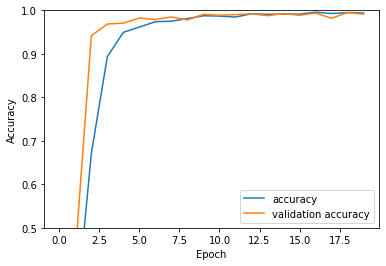

In [9]:
# plots

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [10]:
# Test Accuracy

test_loss, test_acc = model.evaluate(test_ds)
print(test_acc)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


64/64 [==============================] - 91s 1s/step - loss: 0.9287 - accuracy: 0.8128
0.8127785921096802


In [11]:
# y_pred and y_true for calculating metrics

y_pred_t=model.predict(test_ds)
y_pred=np.argmax(y_pred_t, axis=1)

y_true = np.concatenate([y for x, y in test_ds], axis=0)

In [12]:
# Top 2 accuracy

top_k_accuracy_score(y_true, y_pred_t, k=2)

0.8781575037147102

In [13]:
# Confusion matrix

cm=confusion_matrix(y_true, y_pred)
print(cm)

[[148   6   0   8   1   0   0   1   3  47]
 [  0 160   3  17   0   0   6   0  36   2]
 [  1   0 186   0   0   0   1   0  28   5]
 [  5   2   0 211   0   0   0   0   0   2]
 [  0   4   0   7 200   0   1   0  11   0]
 [  0   0   0   0   0 226   0   0   0   0]
 [  0   0   0   0   6   0 192   0   5   0]
 [ 10   4   0   0   1   1   2  99  52   0]
 [ 16   0   0   4  21   3   1   1 106   7]
 [ 42   1   0   3   0   1   0   0   0 113]]


In [14]:
# Precision

print(precision_score(y_true,y_pred,average='micro'))

0.812778603268945


In [15]:
# Recall

print(recall_score(y_true,y_pred,average='micro'))

0.812778603268945


In [16]:
# F1 Score

print(f1_score(y_true,y_pred,average='micro'))

0.812778603268945


In [17]:
# Classification Report 

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.69      0.68       214
           1       0.90      0.71      0.80       224
           2       0.98      0.84      0.91       221
           3       0.84      0.96      0.90       220
           4       0.87      0.90      0.88       223
           5       0.98      1.00      0.99       226
           6       0.95      0.95      0.95       203
           7       0.98      0.59      0.73       169
           8       0.44      0.67      0.53       159
           9       0.64      0.71      0.67       160

    accuracy                           0.81      2019
   macro avg       0.83      0.80      0.80      2019
weighted avg       0.84      0.81      0.82      2019

